## Additional Analyses for Logistic Regression

In [ ]:
#Import pre-processed data
import pandas as pd
import numpy as np

file = ".\\data\\processed\\stroke_processed.csv"
df = pd.read_csv(file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


#### A1: Hyperparam tuning for optimizing F1 (instead of recall)

In [4]:
# Split dataset into stroke and non-stroke patients
strokes = df[df['stroke'] == 1]
non_strokes = df[df['stroke'] == 0]

#Split dataset into predictors and outcome vars
X = df.drop(columns=['stroke'])
y = df['stroke']

#change hypertension and heart disease into objects so they are flagged categorical
X[['hypertension', 'heart_disease']] = X[['hypertension', 'heart_disease']].astype('object')

#Update the numeric and categorical cols
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(numerical_cols) 
print(categorical_cols)

['age', 'avg_glucose_level', 'bmi']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [5]:
#Scale the numeric cols and get dummies for categoricals
from sklearn.preprocessing import StandardScaler

categorical_cols = [col for col in categorical_cols if col in X.columns]

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

numerical_cols = [col for col in numerical_cols if col in X.columns]

if numerical_cols:
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.051434,2.706375,1.001234,True,False,True,True,False,True,False,True,True,False,False
1,0.786070,2.121559,0.000000,False,False,False,True,False,False,True,False,False,True,False
2,1.626390,-0.005028,0.468577,True,False,True,True,False,True,False,False,False,True,False
3,0.255342,1.437358,0.715418,False,False,False,True,False,True,False,True,False,False,True
4,1.582163,1.501184,-0.635711,False,True,False,True,False,False,True,False,False,True,False


In [ ]:
#Train test split dataset
from sklearn.model_selection import train_test_split

#Change bools into 1 and 0 numeric
X = X.map(lambda x: 1 if x is True else (0 if x is False else x))

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Check the stroke distribution in the train and test sets, they should be the same
print(f"Training set class distribution: \n{y_train.value_counts(normalize=True)}")
print(f"Test set class distribution: \n{y_test.value_counts(normalize=True)}")

(4088, 14)
(4088,)
(1022, 14)
(1022,)
Training set class distribution: 
stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
Test set class distribution: 
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\linear_model\_logistic.py", line 1

Best parameters: {'C': 0.01, 'class_weight': {0: 1, 1: 10}, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       972
           1       0.20      0.74      0.32        50

    accuracy                           0.85      1022
   macro avg       0.59      0.80      0.62      1022
weighted avg       0.95      0.85      0.88      1022

Accuracy: 0.8454011741682974
[[827 145]
 [ 13  37]]
F1 Score: 0.31896551724137934
Recall: 0.74
Precision: 0.2032967032967033
ROC AUC Score: 0.8427


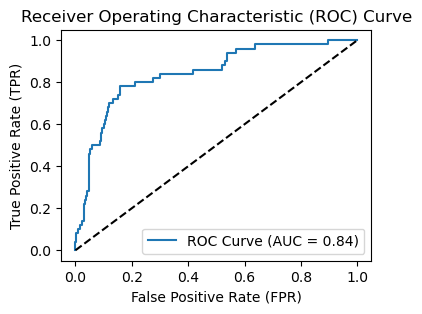

In [7]:
#Fit model with params optimized for F1
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, recall_score
import matplotlib.pyplot as plt

model = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear',  'saga'], #'newton-cg', 'lbfgs',
    'max_iter': [200, 300] ,
    'class_weight': [{0: 1, 1: 5},{0: 1, 1: 10}, 'balanced']
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Fit the model with the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model with the best hyperparameters
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

precision= precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Get probabilities for class 1 (stroke patients)
y_prob = best_model.predict_proba(X_test)[:, 1]  

#Calculate AUC and plot the ROC curve
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### A2: Try lowering decision threshold

In [ ]:
# Make predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class

# Change the threshold (default 0.5) to something lower
y_pred = (y_prob > 0.45).astype(int)

# Evaluate the model using your custom threshold
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

#Compared to the best_model in Addt analysis 1 above, the tradeoff is fewer false negatives but more false positives
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       972
           1       0.18      0.78      0.30        50

    accuracy                           0.82      1022
   macro avg       0.59      0.80      0.60      1022
weighted avg       0.95      0.82      0.87      1022

[[799 173]
 [ 11  39]]


#### A3: Smaller sample of non-stroke patients 
Due to class imbalance (outcome is <5%), try modelling a smaller dataset of all stroke patients + sample of non-stroke patients

In [10]:
# Split dataset into all stroke patients and 5x the number of non-stroke patients (or try other ratios to see if improve model performance)
strokes = df[df['stroke'] == 1]
non_strokes = df[df['stroke'] == 0]
non_strokes_sample = non_strokes.sample(n=1245, random_state= 47) 

df_balanced = pd.concat([strokes, non_strokes_sample])

# Shuffle the dataset to mix stroke and non-stroke patients randomly, frac=1 to use 100% of the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#Split dataset into predictors and outcome vars
X = df_balanced.drop(columns=['stroke'])
y = df_balanced['stroke']

In [ ]:
#Sort out numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(numerical_cols)
print(categorical_cols)

#change hypertension and heart disease into objects so they are flagged categorical
X[['hypertension', 'heart_disease']] = X[['hypertension', 'heart_disease']].astype('object')

#Update the numeric and categorical cols
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(numerical_cols) 
print(categorical_cols)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
['age', 'avg_glucose_level', 'bmi']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [12]:
#Scale the numeric cols and get dummies for categoricals
from sklearn.preprocessing import StandardScaler

categorical_cols = [col for col in categorical_cols if col in X.columns]

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

numerical_cols = [col for col in numerical_cols if col in X.columns]

if numerical_cols:
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,-0.050139,-0.425364,-0.176296,False,False,False,True,False,True,False,True,True,False,False
1,-0.392673,-0.661545,-1.019093,False,False,False,False,False,False,False,False,False,True,False
2,-0.649574,-0.958590,0.877200,False,False,False,False,False,False,True,True,False,True,False
3,-0.135772,-0.473490,0.547982,False,False,False,True,False,True,False,True,False,True,False
4,-1.891261,-0.327696,-1.545841,True,False,False,False,True,False,False,True,False,False,False


In [13]:
#Split into training and test
from sklearn.model_selection import train_test_split

#Change bools into 1 and 0 numeric
X = X.map(lambda x: 1 if x is True else (0 if x is False else x))

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Check the stroke distribution in the train and test sets, they should be the same
print(f"Training set class distribution: \n{y_train.value_counts(normalize=True)}")
print(f"Test set class distribution: \n{y_test.value_counts(normalize=True)}")

(1195, 14)
(1195,)
(299, 14)
(299,)
Training set class distribution: 
stroke
0    0.833473
1    0.166527
Name: proportion, dtype: float64
Test set class distribution: 
stroke
0    0.832776
1    0.167224
Name: proportion, dtype: float64


In [14]:
#Fit the model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

Accuracy: 0.7491638795986622
[[187  62]
 [ 13  37]]
F1 Score: 0.4966442953020134
Recall: 0.74
ROC AUC Score: 0.8340


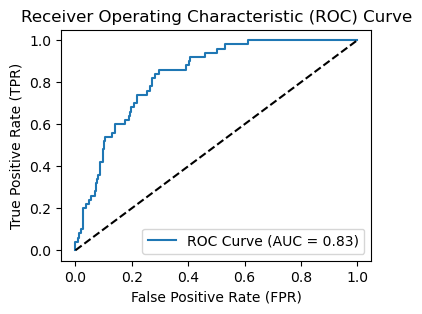

In [15]:
#Predict outcome on test set
y_pred = model.predict(X_test)

#Get model performance metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, recall_score
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# y_test: true labels, y_pred: predicted labels
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")

# Get probabilities for class 1 (stroke patients)
y_prob = model.predict_proba(X_test)[:, 1]  

#Calculate AUC and plot the ROC curve
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
#Check coefficient betas
import pandas as pd
import numpy as np

coefficients = model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df)

                           Feature  Coefficient  Abs_Coefficient
0                              age     1.856920         1.856920
7           work_type_Never_worked     0.934956         0.934956
4                   hypertension_1     0.481924         0.481924
12     smoking_status_never smoked    -0.470478         0.470478
6                 ever_married_Yes    -0.349695         0.349695
5                  heart_disease_1     0.308518         0.308518
3                      gender_Male    -0.129543         0.129543
2                              bmi     0.125750         0.125750
1                avg_glucose_level     0.125737         0.125737
10            Residence_type_Urban     0.117333         0.117333
8                work_type_Private     0.091241         0.091241
13           smoking_status_smokes    -0.074331         0.074331
9          work_type_Self-employed    -0.055581         0.055581
11  smoking_status_formerly smoked    -0.017362         0.017362


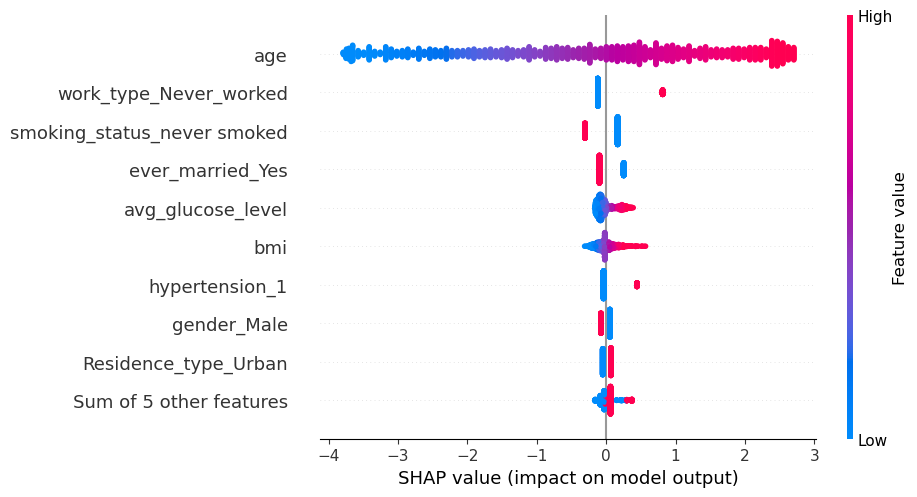

In [18]:
# SHAP values
import shap

explainer = shap.LinearExplainer(model, X_train)

# Calculate SHAP values for your dataset (e.g., the first few rows of X_train)
shap_values = explainer(X_train)

# Convert SHAP values to a standard NumPy array with numerical data type
shap_values_array = shap_values.values  # Access the raw SHAP values

# If shap_values_array is a list of arrays, convert it to a single array
if isinstance(shap_values_array, list) and all(isinstance(item, np.ndarray) for item in shap_values_array):
    shap_values_array = np.concatenate(shap_values_array)

# Ensure the data type is compatible with NumPy's round function
shap_values_array = shap_values_array.astype(np.float64)

# Create a new Explanation object with the converted SHAP values
shap_values_converted = shap.Explanation(
    values=shap_values_array,
    base_values=shap_values.base_values,
    data=shap_values.data,
    feature_names=shap_values.feature_names,
    display_data=shap_values.display_data,
)

# Beeswarm plot using the converted SHAP values
shap.plots.beeswarm(shap_values_converted)

Sensitivity analysis: test on the non-stroke patients that didn't make it into the df_balanced sample

In [19]:
#Identify the non-stroke sample who didn't make it into df_balanced
non_strokes_remaining = non_strokes[~non_strokes.index.isin(df_balanced.index)]

#Preprocess the columns
X_remaining = non_strokes_remaining.drop(columns=['stroke'])
y_remaining = non_strokes_remaining['stroke']

X_remaining[['hypertension', 'heart_disease']] = X_remaining[['hypertension', 'heart_disease']].astype('object')

numerical_cols = X_remaining.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_remaining.select_dtypes(include=['object']).columns.tolist()

print(numerical_cols) 
print(categorical_cols)

# Scale and get dummies
categorical_cols = [col for col in categorical_cols if col in X_remaining.columns]

X_remaining = pd.get_dummies(X_remaining, columns=categorical_cols, drop_first=True)

numerical_cols = [col for col in numerical_cols if col in X_remaining.columns]

if numerical_cols:
    scaler = StandardScaler()
    X_remaining[numerical_cols] = scaler.fit_transform(X_remaining[numerical_cols])

['age', 'avg_glucose_level', 'bmi']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [ ]:
# Recombine the remaining unsampled non-stroke patients back into the test set
X_recombined = pd.concat([X_test, X_remaining])  
y_recombined = pd.concat([y_test, y_remaining])  

# Test the model on the data that includes the remaining non-stroke patients
y_pred_recombined = model.predict(X_recombined)
y_prob_recombined = model.predict_proba(X_recombined)[:, 1]

# Print performance metrics
print("Accuracy: ", accuracy_score(y_recombined, y_pred_recombined)) 
print("F1 score: ", f1_score(y_recombined, y_pred_recombined))
print("Recall: ", recall_score(y_recombined, y_pred_recombined))
print(confusion_matrix(y_recombined, y_pred_recombined) )
print("AUC: ", roc_auc_score(y_recombined, y_prob_recombined))

#same recall of 0.74 but much lower F1 score due to lots of false positives
#that means the model was overfit

Accuracy:  0.6710089399744572
F1 score:  0.05433186490455213
Recall:  0.74
[[2590 1275]
 [  13   37]]
AUC:  0.782882276843467


#### A4: Age as categorical variable
Stroke risk rises rapidly after [age 55](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/stroke-in-canada.html)

In [40]:
# Split dataset into stroke patients vs no stroke
strokes = df[df['stroke'] == 1]
non_strokes = df[df['stroke'] == 0]

In [41]:
#Split dataset into predictors and outcome vars
X = df.drop(columns=['stroke'])
y = df['stroke']

In [42]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [43]:
#change hypertension and heart disease into objects so they are flagged categorical
X[['hypertension', 'heart_disease']] = X[['hypertension', 'heart_disease']].astype('object')

#Update the numeric and categorical cols
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(numerical_cols) 
print(categorical_cols)

['age', 'avg_glucose_level', 'bmi']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [44]:
# Define age bins and labels
agebins = [0, 55, 65, 75, float('inf')]  
agelabels = ['<55', '55-65', '65-75', '75+']

# Create the new categorical column for age groups
X['age_group'] = pd.cut(X['age'], bins=agebins, labels=agelabels, right=False)

# Encode new categorical column with pd.get_dummies
categorical_cols = [col for col in categorical_cols if col in X.columns]

# Add the new 'age_group' column to categorical_cols
categorical_cols.append('age_group')

In [45]:
#Remove age from continuous
numerical_cols = [col for col in numerical_cols if col != 'age']
print(numerical_cols)
print(categorical_cols)

['avg_glucose_level', 'bmi']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_group']


In [46]:
#Scale the numeric cols and get dummies for categoricals
from sklearn.preprocessing import StandardScaler

X = X.drop(columns=['age'])

categorical_cols = [col for col in categorical_cols if col in X.columns]

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

numerical_cols = [col for col in numerical_cols if col in X.columns]

if numerical_cols:
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   avg_glucose_level               5110 non-null   float64
 1   bmi                             5110 non-null   float64
 2   gender_Male                     5110 non-null   bool   
 3   hypertension_1                  5110 non-null   bool   
 4   heart_disease_1                 5110 non-null   bool   
 5   ever_married_Yes                5110 non-null   bool   
 6   work_type_Never_worked          5110 non-null   bool   
 7   work_type_Private               5110 non-null   bool   
 8   work_type_Self-employed         5110 non-null   bool   
 9   Residence_type_Urban            5110 non-null   bool   
 10  smoking_status_formerly smoked  5110 non-null   bool   
 11  smoking_status_never smoked     5110 non-null   bool   
 12  smoking_status_smokes           51

In [47]:
#Check collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# One-hot encoding
X_copy = X.copy()

#Turn booleans into numeric
X_copy = X_copy.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Add constant term for intercept in VIF calculation
X_copy = add_constant(X_copy)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_copy.columns
vif_data["VIF"] = [variance_inflation_factor(X_copy.values, i) for i in range(X_copy.shape[1])]

print(vif_data)

#All VIF values are <5

                           feature        VIF
0                            const  17.848406
1                avg_glucose_level   1.109573
2                              bmi   1.317265
3                      gender_Male   1.030782
4                   hypertension_1   1.111140
5                  heart_disease_1   1.117748
6                 ever_married_Yes   1.649679
7           work_type_Never_worked   2.828433
8                work_type_Private   2.352639
9          work_type_Self-employed   1.964322
10            Residence_type_Urban   1.002473
11  smoking_status_formerly smoked   1.592177
12     smoking_status_never smoked   1.781963
13           smoking_status_smokes   1.538682
14                 age_group_55-65   1.209384
15                 age_group_65-75   1.240462
16                   age_group_75+   1.326493


C:\Users\Catren-PC\AppData\Local\Temp\ipykernel_23428\2474550424.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_copy = X_copy.applymap(lambda x: 1 if x is True else (0 if x is False else x))


In [48]:
from sklearn.model_selection import train_test_split

#Change bools into 1 and 0 numeric
X = X.map(lambda x: 1 if x is True else (0 if x is False else x))

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4088, 16)
(4088,)
(1022, 16)
(1022,)


In [49]:
# Check the stroke distribution in the train and test sets, they should be the same
print(f"Training set class distribution: \n{y_train.value_counts(normalize=True)}")
print(f"Test set class distribution: \n{y_test.value_counts(normalize=True)}")

Training set class distribution: 
stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
Test set class distribution: 
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


In [50]:
#Fit the model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [51]:
#Predict outcome on test set
y_pred = model.predict(X_test)

Accuracy: 0.7299412915851272
[[706 266]
 [ 10  40]]
F1 Score: 0.2247191011235955
Recall: 0.8
ROC AUC Score: 0.8344


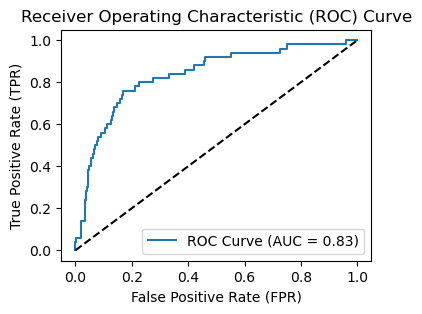

In [52]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, recall_score
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# y_test: true labels, y_pred: predicted labels
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")
# Get probabilities for class 1 (stroke patients)
y_prob = model.predict_proba(X_test)[:, 1]  

#Calculate AUC and plot the ROC curve
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

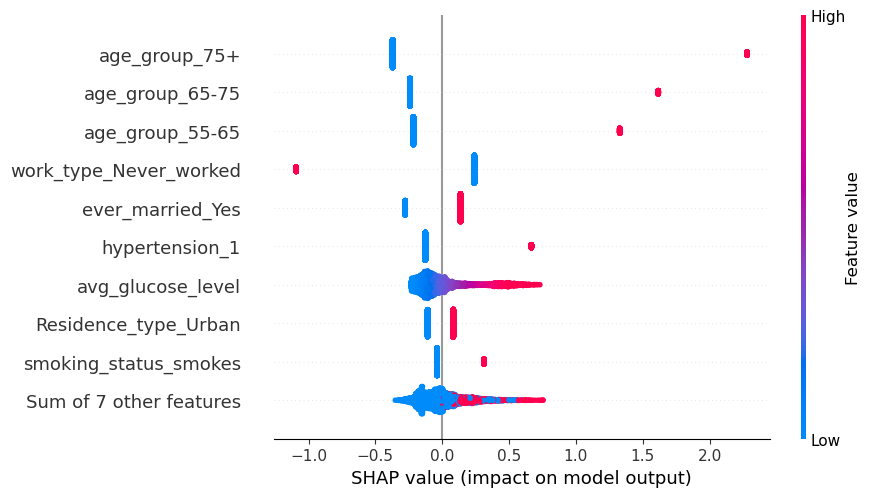

In [ ]:
# SHAP values
import shap

explainer = shap.LinearExplainer(model, X_train)

# Calculate SHAP values for your dataset (e.g., the first few rows of X_train)
shap_values = explainer(X_train)
 
# Visualize the SHAP values for the first instance (index 0) using a waterfall plot
#shap.plots.waterfall(shap_values[1]) 
 
shap_values_array = shap_values.values  # Access the raw SHAP values

# Convert shap_values_array into a single array
if isinstance(shap_values_array, list) and all(isinstance(item, np.ndarray) for item in shap_values_array):
    shap_values_array = np.concatenate(shap_values_array)

# Ensure the data type is compatible with float64
shap_values_array = shap_values_array.astype(np.float64)

# Create a new Explanation object with the converted SHAP values
shap_values_converted = shap.Explanation(
    values=shap_values_array,
    base_values=shap_values.base_values,
    data=shap_values.data,
    feature_names=shap_values.feature_names,
    display_data=shap_values.display_data,
)

# Beeswarm plot
shap.plots.beeswarm(shap_values_converted)

#Age 75+ has the highest risk

#### A5: Dealing with large proportion of unknown smoking status
Potential options: <br>
1) remove all records with unknown smoking status - not ideal bc 30% of dataset (19% of stroke patients) have unknown smoking
2) group smoking into smoke yes/no- randomize unknowns into y/n
3) impute with random value: never, former, current
3) impute with complex technique

In [54]:
df['smoking_status'].value_counts()
#Large number of unknowns

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [55]:
pd.crosstab(df['stroke'], df['smoking_status']) 

smoking_status,Unknown,formerly smoked,never smoked,smokes
stroke,,,,
0,1497,815,1802,747
1,47,70,90,42


In [56]:
#Option 3: Randomly assign to never, former, or current smoker
import random

df2= df.copy()

unknown_mask = df2['smoking_status'] == 'Unknown'
unknown_indices = df2[unknown_mask].index

# Randomly assign smoking status to unknowns
smoking_statuses = ['never smoked', 'formerly smoked', 'smokes']
for index in unknown_indices:
    df2.loc[index, 'smoking_status'] = random.choice(smoking_statuses)

In [57]:
df2['smoking_status'].value_counts()

smoking_status
never smoked       2377
formerly smoked    1396
smokes             1337
Name: count, dtype: int64

In [58]:
pd.crosstab(df2['stroke'], df2['smoking_status']) 

smoking_status,formerly smoked,never smoked,smokes
stroke,,,
0,1308,2271,1282
1,88,106,55


Considered KNN imputation for option 4 but did not pursue further due to large proportion unknown, avoid bias